# Toy Model 

## Basic Model



In [15]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm

In [18]:
def grad_U(data, theta, N, n):
    mu = theta[0]
    gamma = theta[1]

    sigma_x = np.sum(x)
    sigma_x2 = np.sum((x-mu)**2)

    d_mu = (N+1) * mu * gamma - gamma * N * sigma_x / n 
    d_gamma = 1 - (N+1)/(2*gamma) + mu**2/2 +N *sigma_x2 / (2*n)

    return np.array([d_mu, d_gamma])


def calculate_V(data, theta, N, n):

    g_theta_mean = grad_U(data, theta, N, n)

    V = np.zeros((2,2))

    for i in range(len(data)):
        g_theta_i = grad_U([data[i]], theta, N, n) - g_theta_mean
        V += np.outer(g_theta_i, g_theta_i)

    return V

def update_I(t, V, I_old):
    kappa = 1/t
    I_new = (1-kappa) * I_old + kappa*V
    return I_new

def update_p(p_old, h, U_theta, N, n, I_new, xi_old, A):
    p_new = p_old - U_theta * h - (h/2)* (N**2/n) * np.dot(I_new, p_old) * h - np.dot(xi_old, p_old) * h + np.sqrt(2*A*h) * np.random.normal(0, 1, 1)
    return p_new

def update_xi(xi_old, p_new, N_d, h):
    xi_new = xi_old +(np.outer(p_new, p_new) / (N_d - 1)) * h
    return xi_new


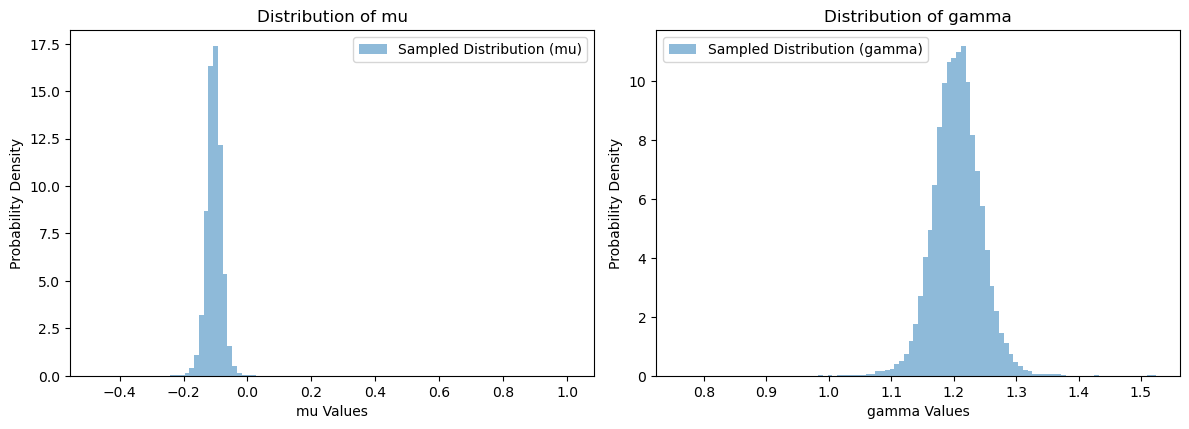

In [36]:
h = 0.01
A = 1
xi = A
theta = np.array([1,1])
p = np.array([1,1])
I = np.eye(2)

N_d = len(theta)

# Set the seed for reproducibility (optional)
np.random.seed(42)

# Number of samples
N = 100

# Generate N samples from a standard normal distribution
data = np.random.normal(0, 1, N)

n = 20

# Arrays to store sampled values
mu_samples = []
gamma_samples = []

# Number of samples for plotting the true distribution
plot_samples = 100000

for t in range(1, 100000):
    x = data[np.random.randint(0, N, n)]
    theta = theta + p*h
    V = calculate_V(x, theta, N, n)
    I = update_I(t, V, I)
    U_theta = grad_U(x, theta, N, n)
    p = update_p(p, h, U_theta, N, n, I, xi, A)
    xi = update_xi(xi, p, N_d, h)

    # Collect samples for plotting
    if t % 1 == 0:
        mu_samples.append(theta[0])
        gamma_samples.append(theta[1])

# Apply clipping to limit the range of sampled values
mu_samples_clipped = np.clip(mu_samples, -5, 5)
gamma_samples_clipped = np.clip(gamma_samples, -5, 5)


# Plotting the marginal distributions of mu and gamma
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(mu_samples_clipped, bins=100, density=True, alpha=0.5, label='Sampled Distribution (mu)')
plt.title('Distribution of mu')
plt.xlabel('mu Values')
plt.ylabel('Probability Density')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(gamma_samples_clipped, bins=100, density=True, alpha=0.5, label='Sampled Distribution (gamma)')
plt.title('Distribution of gamma')
plt.xlabel('gamma Values')
plt.ylabel('Probability Density')
plt.legend()

plt.tight_layout()
plt.show()


In [37]:
print(mu_samples[-1])

-0.11113868842236795



## BAOAB Integrator 

*Model description*